In [18]:
data_dir = '/content/drive/MyDrive/All-datasets/NLP/jena_climate_2009_2016.csv'

f = open(data_dir)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [19]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

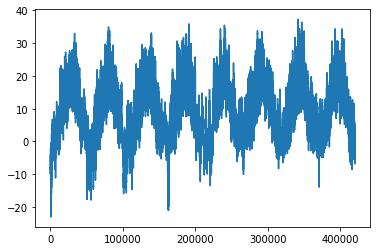

In [21]:
from matplotlib import pyplot as plt


temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

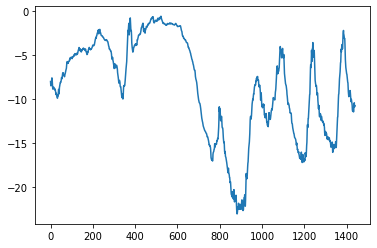

In [22]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [23]:
#Preparing the data
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [ ]:
#lookback = 720, i.e. our observations will go back 5 days.
#steps = 6, i.e. our observations will be sampled at one data point per hour.
#delay = 144, i.e. our targets will be 24 hours in the future.

In [39]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

In [40]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [41]:
from keras.models import Sequential
from keras import layers
from keras import models 
from tensorflow.keras.optimizers import RMSprop

model = models.Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=1000)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


500/500 [==============================] - 17s 34ms/step - loss: 1.8690 - val_loss: 1.0413
Epoch 2/20
500/500 [==============================] - 17s 34ms/step - loss: 0.6580 - val_loss: 0.4832
Epoch 3/20
500/500 [==============================] - 16s 33ms/step - loss: 0.3292 - val_loss: 0.3423
Epoch 4/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2770 - val_loss: 0.3039
Epoch 5/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2613 - val_loss: 0.3272
Epoch 6/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2508 - val_loss: 0.3176
Epoch 7/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2432 - val_loss: 0.3136
Epoch 8/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2344 - val_loss: 0.3377
Epoch 9/20
500/500 [==============================] - 15s 31ms/step - loss: 0.2328 - val_loss: 0.3297
Epoch 10/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2260 - val_los

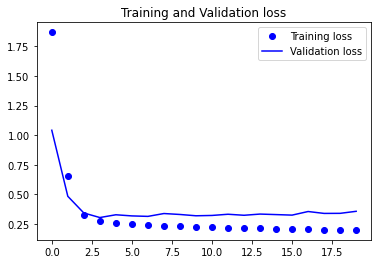

In [42]:
import matplotlib.pyplot as plt       

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [44]:
from keras.models import Sequential  
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))


model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


500/500 [==============================] - 110s 216ms/step - loss: 0.3053 - val_loss: 0.2687
Epoch 2/20
500/500 [==============================] - 125s 250ms/step - loss: 0.2837 - val_loss: 0.2688
Epoch 3/20
500/500 [==============================] - 113s 226ms/step - loss: 0.2776 - val_loss: 0.2628
Epoch 4/20
500/500 [==============================] - 133s 266ms/step - loss: 0.2747 - val_loss: 0.2615
Epoch 5/20
500/500 [==============================] - 94s 187ms/step - loss: 0.2703 - val_loss: 0.2621
Epoch 6/20
500/500 [==============================] - 91s 182ms/step - loss: 0.2669 - val_loss: 0.2731
Epoch 7/20
500/500 [==============================] - 91s 181ms/step - loss: 0.2610 - val_loss: 0.2645
Epoch 8/20
500/500 [==============================] - 93s 186ms/step - loss: 0.2547 - val_loss: 0.2676
Epoch 9/20
500/500 [==============================] - 97s 194ms/step - loss: 0.2532 - val_loss: 0.2769
Epoch 10/20
500/500 [==============================] - 91s 182ms/step - loss: 0.

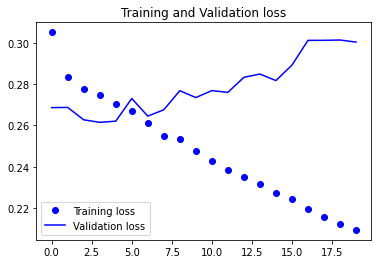

In [45]:
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [46]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop


model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))

model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


500/500 [==============================] - 159s 314ms/step - loss: 0.3400 - val_loss: 0.2793
Epoch 2/5
500/500 [==============================] - 159s 319ms/step - loss: 0.3046 - val_loss: 0.2808
Epoch 3/5
500/500 [==============================] - 159s 319ms/step - loss: 0.2991 - val_loss: 0.2783
Epoch 4/5
500/500 [==============================] - 159s 319ms/step - loss: 0.2949 - val_loss: 0.2719
Epoch 5/5
500/500 [==============================] - 162s 325ms/step - loss: 0.2925 - val_loss: 0.2733


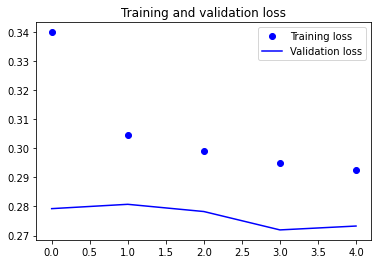

In [47]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [49]:
#Stacking recurrent layers

from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


500/500 [==============================] - 500s 878ms/step - loss: 0.3214 - val_loss: 0.2810
Epoch 2/5
500/500 [==============================] - 437s 875ms/step - loss: 0.3023 - val_loss: 0.2690
Epoch 3/5
500/500 [==============================] - 438s 877ms/step - loss: 0.2934 - val_loss: 0.2726
Epoch 4/5
500/500 [==============================] - 435s 870ms/step - loss: 0.2871 - val_loss: 0.2733
Epoch 5/5
500/500 [==============================] - 447s 895ms/step - loss: 0.2808 - val_loss: 0.2688


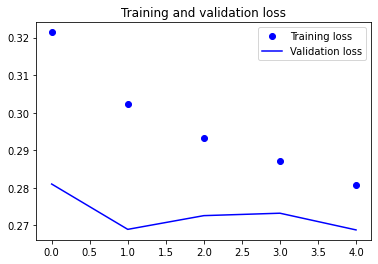

In [50]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()